<a href="https://colab.research.google.com/github/umbertodicanito/Stochastic-Training-of-Graph-Convolutional-Networks-with-Variance-Reduction/blob/master/Cora_GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

#Imports

In [0]:
!pip install dgl

     |████████████████████████████████| 2.4MB 3.4MB/s 


In [0]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from dgl import DGLGraph
from google.colab import files
import warnings
import matplotlib.pyplot as plt

gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

**Original GCN was created by:** `Qi Huang <https://github.com/HQ01>`_, `Minjie Wang  <https://jermainewang.github.io/>`_,
Yu Gai, Quan Gan, Zheng Zhang

The actual GCN is been modified but it is based on these authors work.


#Building matrices for algorithm 1 execution

In [0]:
from dgl.data import citation_graph as citegrh
import networkx as nx
def load_cora_data():
    data = citegrh.load_cora()
    features = th.FloatTensor(data.features)
    labels = th.LongTensor(data.labels)
    mask = th.ByteTensor(data.train_mask)
    g = data.graph
    print(g)
    # add self loop
    g.remove_edges_from(nx.selfloop_edges(g))
    g = DGLGraph(g)
    g.add_edges(g.nodes(), g.nodes())
    return g, features, labels, mask
    
#get data
g, features, labels, mask = load_cora_data()

Extracting file to /root/.dgl/cora



In [0]:
plain_deg_matrix = th.tensor(np.zeros((2708,2708)))
for i in range(2708):
  d = len(g.adjacency_matrix()[i]._indices()[0])
  plain_deg_matrix[i][i] = d

/usr/local/lib/python3.6/dist-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


In [0]:
plain_deg_matrix

tensor([[6., 0., 0.,  ..., 0., 0., 0.],
        [0., 2., 0.,  ..., 0., 0., 0.],
        [0., 0., 5.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 5., 0., 0.],
        [0., 0., 0.,  ..., 0., 5., 0.],
        [0., 0., 0.,  ..., 0., 0., 4.]], dtype=torch.float64)

In [0]:
import math
deg_matrix = th.tensor(np.zeros((2708,2708)))
for i in range(2708):
  d = len(g.adjacency_matrix()[i]._indices()[0])
  deg_matrix[i][i] = math.pow(d,-0.5)

/usr/local/lib/python3.6/dist-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


This is the diagonal degree matrix.
This means that the degree of a node `'v'` with value `'d'`, is stored at `D[u][u]=d`, whereas all the other values of the matrix (except the diagonal) are equal to 0.

In [0]:
deg_matrix

tensor([[0.4082, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.7071, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4472,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.4472, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.4472, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.5000]],
       dtype=torch.float64)

In [0]:
g.adjacency_matrix().to_dense()

/usr/local/lib/python3.6/dist-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

This is the propagation matrix P

In [0]:
P = th.mm(th.mm(deg_matrix.float(),g.adjacency_matrix().to_dense().float()),deg_matrix.float())
print(P.shape)
print(P)

/usr/local/lib/python3.6/dist-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


torch.Size([2708, 2708])
tensor([[0.1667, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.2000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2500]])


The object `g` allows us to get more easily the neighboors nodes.


In [0]:
warnings.filterwarnings('ignore')
r = random.randint(0,2707)
print("Node " + str(r))
g.adjacency_matrix()[r]._indices()[0]

Node 626


tensor([261, 687, 626])

In [0]:
a = list(g.adjacency_matrix()[r]._indices()[0].numpy())
a.remove(r)
print(type(a))
print(a)

<class 'list'>
[261, 687]


This is a simple method used to transforma a list into a torch.Tensor object corresponding to a mask.

In [0]:
def createMask(array):
  a = []
  for i in range(2708):
    if i in array:
      a.append(1)
    else:
      a.append(0)
  m = th.ByteTensor(a)
  return m

#Implementing algorithm 1

The following algorithm is used in order to retrive the receptive fields of each layer and the propagation matrices for each layer, just for the selected minibath of nodes.

The algorithm is used in algorithm for training with CV approach.

Pseudo-code:



```
r_L = V_B
for layer l = L - 1 to 0 do
  r_l = 0
  P'_l = 0
  for each node u in r_l+1 do
    r_l = r_l + {u}
    P'_uu^l = P'_uu^l + P_uu*n(u)/D_l
    for D_l - 1 random neighbors v in n(u) do
      r_l = r_l + {v}
      P'_uv^l = P'_uv^l + P_uv*n(u)/D_l
    end for
  end for
end for
```
where


*   r_L: the receptive field of layer L
*   V_B: the minibatch set (a subset of nodes)
*   P'_l: propagation matrix of the layer l
*   P'_uv^l = P_uv^l * n(u)/D_l, if v is in n'(u)_l, otherwise 0
*   n(u): neighbors of u
*   n'(u): random subset of n(u)
*   D_l: neighbors for each node at layer l

Notice that, since we do not use MINIbatches, n(u)/D_l is always equal to 1.



In [0]:
import time
#implementation of the above algorithm#

#minibatch = th.ByteTensor(...) of 0,1 boolean (it is a mask)

#returning: the receptive fields and the propagation matrices
def algOne(minibatch):
  t0 = time.time()
  rL = minibatch
  l = 2
  n = 2

  receptiveField = dict()
  propagationMatrix = dict()

  receptiveField[l] = rL

  #first for-loop
  while l > 0:
    #init
    field = []
    matrixP = np.zeros((2708,2708))
    #second for-loop
    k = 0
    passedMask = False
    for nodeValue in receptiveField[l]:
      if nodeValue == 1:
        node = k

        if node not in field:
          field.append(node)

        matrixP[node][node] = matrixP[node][node] + P[node][node] * plain_deg_matrix[node][node] / n

        #collecting n random neighbor
        subset = []
        a = list(g.adjacency_matrix()[node]._indices()[0].numpy())
        a.remove(node)
        if len(a) <= n:
          subset = a
        else:
          subset = random.sample(a, k=n)

        #last for-loop
        for neighbor in subset:
          if neighbor not in field:
            field.append(neighbor)
          matrixP[node][neighbor] = matrixP[node][neighbor] + P[node][neighbor] * plain_deg_matrix[node][node] / n

      k = k + 1
      
    #updating level
    l = l - 1

    #convert field (array of nodes) to a mask
    receptiveField[l] = createMask(field).detach()
    propagationMatrix[l] = th.FloatTensor(matrixP).detach()
  
  #print(time.time() - t0)
  return [receptiveField, propagationMatrix]

#Model


Some commond parameters used to train the NN

In [0]:
n_of_training_cycles = 15
n_of_epochs = 150

This methods creates some random masks.

In [0]:
#random mask
masks = []
n_masks = 10
size_masks = 100
a = range(2708)
for i in range(n_masks):
  mask = np.zeros(2708)
  sub = random.sample(a,k=size_masks)
  for s in sub:
    mask[s] = 1
  m = th.ByteTensor(mask)
  masks.append(m)

print("Generated " + str(n_masks) + " random masks with size " + str(size_masks))

Generated 10 random masks with size 100


We then define the node UDF for ``apply_nodes``, which is a fully-connected layer:



In [0]:
class NodeApplyModule(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        z = self.linear(node.data['h'])
        h = self.activation(z)
        return {'h' : h}

We then proceed to define the GCN module. A GCN layer essentially performs
message passing on all the nodes then applies the `NodeApplyModule`. Note
that we omitted the dropout in the paper for simplicity.



In [0]:
class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(GCN, self).__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)

    def forward(self, g, feature):
        g.ndata['h'] = feature
        g.update_all(gcn_msg, gcn_reduce)
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')

The forward function is essentially the same as any other commonly seen NNs
model in PyTorch.  We can initialize GCN like any ``nn.Module``. For example,
let's define a simple neural network consisting of two GCN layers. Suppose we
are training the classifier for the cora dataset (the input feature size is
1433 and the number of classes is 7).



In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.gcn1 = GCN(1433, 16, F.relu)
        self.gcn2 = GCN(16, 7, F.relu)

    def forward(self, g, features):
        x = self.gcn1(g, features)
        x = self.gcn2(g, x)
        return x
        
net = Net()
print(net)

Net(
  (gcn1): GCN(
    (apply_mod): NodeApplyModule(
      (linear): Linear(in_features=1433, out_features=16, bias=True)
    )
  )
  (gcn2): GCN(
    (apply_mod): NodeApplyModule(
      (linear): Linear(in_features=16, out_features=7, bias=True)
    )
  )
)


We load the cora dataset using DGL's built-in data module.



We then train the network as follows:



This is the implementation of a standard GCN with 2 layers (+ 1 input layer). 

In [0]:
import time
import collections
import numpy as np
warnings.filterwarnings('ignore')

#init counters
averageAccCora = []
averageLossCora = []

for t in range(n_of_training_cycles):
  print("Starting new training")
  #get data from DGL
  net = Net()
  g, features, labels, mask = load_cora_data()
  print(g)

  #point to show on graph
  pointsCora=dict()
  pointsLossCora=dict()

  #the number of masks to get when training per epoch
  n_masks_to_try = 4
  #initializing the optimizer (optimizer takes care of optimize the learining rate during training)
  optimizer = th.optim.Adam(net.parameters(), lr=2e-2)
  optimizer.state = collections.defaultdict(dict)

  #dur is just an array to store the duration in order to show them later
  dur = []

  #this 'for' cycles on 200 epochs
  for epoch in range(n_of_epochs):
      t0 = time.time()

      #getting only some masks (4)
      masksToTry = random.sample(masks,n_masks_to_try)

      for m in masksToTry:
          #calling 'net(...)' it asks to the GCN to compute the forward    

          logits = net(g, features)
          logp = F.log_softmax(logits, 1)

          #compute loss like the negative log likelihood loss
          loss = F.nll_loss(logp[m], labels[m])
          
          #Since the backward() function accumulates gradients, and you 
          #don’t want to mix up gradients between minibatch, you have 
          #to zero them out at the start of a new minibatch. This is 
          #exactly like how a general (additive) accumulator variable is 
          #initialized to 0 in code.
          optimizer.zero_grad()

          #update network weights by loss
          loss.backward()

          #update optimizer's values after backward
          optimizer.step()

          #computing accuracy
          i = 0
          matched = 0
          while i < 2708:
            if m[i] == 0:
              #getting index of the maximum
              j = 0
              max = None
              jMax = 0
              for a in logp[i]:
                if max==None:
                  max = a.item()
                  jMax = j
                elif max < a.item():
                  max = a.item()
                  jMax = j
                j = j + 1
              if jMax == labels[i]:
                matched = matched + 1
            i = i + 1
          acc = matched/(2708-size_masks)*100

          if epoch not in pointsCora:
            pointsCora[epoch] = 0
            pointsLossCora[epoch] = 0
          pointsCora[epoch] = pointsCora[epoch] + acc
          pointsLossCora[epoch] = pointsLossCora[epoch] + loss.item()
          
      dur.append(time.time() - t0)
      
      #computing the average of the accuracy and the loss
      pointsCora[epoch] = pointsCora[epoch]/n_masks_to_try
      pointsLossCora[epoch] = pointsLossCora[epoch]/n_masks_to_try

      print("Epoch {:05d} | Loss {:.4f} | Time(s) {:.4f} | Accuracy: {:.6f} %".format(
              epoch, loss.item(), np.mean(dur), pointsCora[epoch]))
  #storing results    
  averageAccCora.append(pointsCora)
  averageLossCora.append(pointsLossCora)
  print("Results stored.")

Starting new training

DGLGraph(num_nodes=2708, num_edges=13264,
         ndata_schemes={}
         edata_schemes={})
Epoch 00000 | Loss 1.6824 | Time(s) 1.2594 | Accuracy: 26.457055 %
Epoch 00001 | Loss 1.2791 | Time(s) 1.2878 | Accuracy: 45.437117 %
Epoch 00002 | Loss 1.3135 | Time(s) 1.2610 | Accuracy: 56.786810 %
Epoch 00003 | Loss 1.2255 | Time(s) 1.2668 | Accuracy: 58.502684 %
Epoch 00004 | Loss 1.0052 | Time(s) 1.2681 | Accuracy: 59.998083 %
Epoch 00005 | Loss 0.9653 | Time(s) 1.2599 | Accuracy: 61.685199 %
Epoch 00006 | Loss 0.9593 | Time(s) 1.2544 | Accuracy: 61.953604 %
Epoch 00007 | Loss 0.7863 | Time(s) 1.2503 | Accuracy: 66.027607 %
Epoch 00008 | Loss 0.8931 | Time(s) 1.2529 | Accuracy: 68.366564 %
Epoch 00009 | Loss 0.8896 | Time(s) 1.2494 | Accuracy: 68.510353 %
Epoch 00010 | Loss 0.8433 | Time(s) 1.2497 | Accuracy: 67.494248 %
Epoch 00011 | Loss 0.7004 | Time(s) 1.2448 | Accuracy: 68.481595 %
Epoch 00012 | Loss 0.8238 | Time(s) 1.2435 | Accuracy: 69.852377 %
Epoch 00013

#On graphic

In [0]:
accPointsCora = [0]*n_of_epochs
lossPointsCora = [0]*n_of_epochs

for d in range(n_of_training_cycles):
  for i in range(n_of_epochs):
    accPointsCora[i] = accPointsCora[i] + averageAccCora[d][i]
    lossPointsCora[i] = lossPointsCora[i] + averageLossCora[d][i]

for i in range(n_of_epochs):
  accPointsCora[i] = accPointsCora[i]/n_of_training_cycles
  lossPointsCora[i] = lossPointsCora[i]/n_of_training_cycles

In [0]:
maxAccCora = np.argmax(accPointsCora)
maxAccCora

83

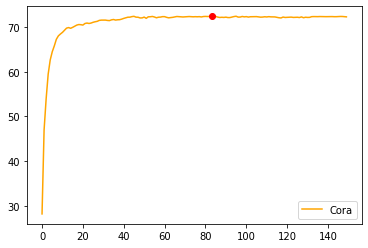

In [0]:
axisX = range(n_of_epochs)

plt.plot(axisX, accPointsCora, color='orange', label='Cora')
#plt.plot(axisX, pointsPubMed, color='blue', label='PubMed')
plt.plot([maxAccCora], accPointsCora[maxAccCora], marker='o', color='red')
#plt.plot([maxAccPubMed], pointsPubMed[maxAccPubMed], marker='o', color='blue')
plt.legend()
plt.show()

In [0]:
print("Max accuracy Cora at {:03d} epochs with value {:05f}"
  .format(maxAccCora, pointsCora[maxAccCora]))
#print("Max accuracy PubMed at {:03d} epochs with value {:05f}"
#  .format(maxAccPubMed, pointsPubMed[maxAccPubMed]))

Max accuracy Cora at 083 epochs with value 72.891104


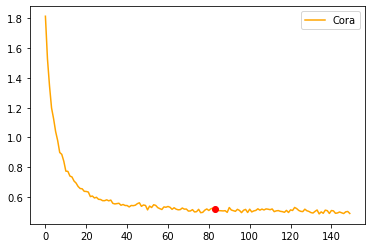

In [0]:
plt.plot(axisX, lossPointsCora, color='orange', label='Cora')
#plt.plot(axisX, pointsLossPubMed, color='blue', label='PubMed')
plt.plot([maxAccCora], lossPointsCora[maxAccCora], marker='o', color='red')
#plt.plot([maxAccPubMed], pointsLossPubMed[maxAccPubMed].item(), marker='o',color='blue')
plt.legend()
plt.show()

In [0]:
print("For Cora, at epoch {:03d}, loss was {:05f}"
  .format(maxAccCora, lossPointsCora[maxAccCora]))
#print("For PubMed, at epoch {:03d}, loss was {:05f}"
#  .format(maxAccPubMed, pointsLossPubMed[maxAccPubMed]))

For Cora, at epoch 083, loss was 0.518383


#Our algorithm

For our algorithm we need to store somewhere some information. In particular for each training cycle we will update the historical activation in order to bring an efficent approximation. Also, we need to store the last recent h_0 and h_1, for computational purpose.

In [0]:
class HMatrices():
  def __init__(self):
    self.historical_activation_1 = th.Tensor(np.zeros((2708,1433)))
    self.historical_activation_2 = th.Tensor(np.zeros((2708,16)))
    self.h_0 = th.Tensor([])
    self.h_1 = th.Tensor([])

  def updateHMatrix(self,features,x):
    self.h_0 = features
    self.h_1 = x
  
  def updateActivation(self, row, level, a):
    if level == 0:
      self.historical_activation_1[row] = a
    elif level == 1:
      self.historical_activation_2[row] = a

In [0]:
class SimpleNodeApplyModule(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(SimpleNodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        #type of node: dgl.udf.NodeBatch
        #type of node.data['h']: torch.Tensor
        z = self.linear(node.data['h'])
        h = self.activation(z)
        return {'h' : h}

In [0]:
class SimpleGCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(SimpleGCN, self).__init__()
        self.apply_mod = SimpleNodeApplyModule(in_feats, out_feats, activation)

    def forward(self, g, feature):
        g.ndata['h'] = feature
        g.update_all(gcn_msg, gcn_reduce)
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')

In [0]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.gcn1 = SimpleGCN(1433, 16, F.relu)
        self.gcn2 = SimpleGCN(16, 7, F.relu)

    def forward(self, g, features, propMatrix, historicalActivation, hContainer):
        #type of 'g': dgl.graph.DGLGraph
        x = self.gcn1(g, features)
        hContainer.updateHMatrix(features, x)
        # CV = (P'_l*(H_l-H'_l)+P*H'_l)
        x = th.mm(propMatrix,x.sub(historicalActivation)).add(th.mm(P,historicalActivation))
        x = self.gcn2(g, x)
        return x

simpleNet = SimpleNet()
print(simpleNet)

SimpleNet(
  (gcn1): SimpleGCN(
    (apply_mod): SimpleNodeApplyModule(
      (linear): Linear(in_features=1433, out_features=16, bias=True)
    )
  )
  (gcn2): SimpleGCN(
    (apply_mod): SimpleNodeApplyModule(
      (linear): Linear(in_features=16, out_features=7, bias=True)
    )
  )
)


In [0]:
import time
import collections
import numpy as np
warnings.filterwarnings('ignore')

#init counters
averageAccCora_our = []
averageLossCora_our = []

for t in range(n_of_training_cycles):
  print("Starting new training cycle")

  simpleNet = SimpleNet()
  #point to show on graph
  pointsOurCora=dict()
  pointsOurLossCora=dict()

  with th.no_grad():
    #get data
    g, features, labels, mask = load_cora_data()

    print(g)
    n_masks_to_try = 4
    ourOptimizer = th.optim.Adam(simpleNet.parameters(), lr=2e-2)
    ourOptimizer.state = collections.defaultdict(dict)
    dur = []

    #running algOne for each mask
    t0 = time.time()
    print("Computing algorithm 1 for each mask...")
    resForMasks = dict()
    for m in masks:
      resForMasks[m] = algOne(m)
    print("{:03f} seconds".format(time.time()-t0))

  #this is an object storing some constant data
  hs = HMatrices()

  for epoch in range(n_of_epochs):
        
      t0 = time.time()
      #getting only some masks (4)
      masksToTry = random.sample(masks,n_masks_to_try)
      for m in masksToTry:
          #calling 'net(...)' it asks to the GCN to compute the forward

          #M=(P'_l*(H_l-H'_l)+P*H'_l)
          #H_l = feature
          #P': progationMatrix
          #H': get from initialized matrix
          #P: computed before
          CV = th.mm(resForMasks[m][1][0],features.sub(hs.historical_activation_1.detach())).add(th.mm(P,hs.historical_activation_1.detach()))
          logits = simpleNet(g, CV, resForMasks[m][1][1], hs.historical_activation_2.detach(), hs)
          logp = F.log_softmax(logits, 1)

          #compute loss like the negative log likelihood loss
          ourLoss = F.nll_loss(logp[m], labels[m])

          #Since the backward() function accumulates gradients, and you 
          #don’t want to mix up gradients between minibatch, you have 
          #to zero them out at the start of a new minibatch. This is 
          #exactly like how a general (additive) accumulator variable is 
          #initialized to 0 in code.
          ourOptimizer.zero_grad()

          #update network weights by loss
          #ourLoss.backward(retain_graph=True)
          ourLoss.backward()

          #update optimizer's values after backward
          ourOptimizer.step()

          #computing accuracy
          i = 0
          matched = 0
          while i < 2708:
            if m[i] == 0:
              #getting index of the maximum
              j = 0
              max = None
              jMax = 0
              for a in logp[i]:
                if max==None:
                  max = a.item()
                  jMax = j
                elif max < a.item():
                  max = a.item()
                  jMax = j
                j = j + 1
              if jMax == labels[i]:
                matched = matched + 1
            i = i + 1
          acc = matched/(2708-size_masks)*100

          if epoch not in pointsOurCora:
            pointsOurCora[epoch] = 0
            pointsOurLossCora[epoch] = 0
          pointsOurCora[epoch] = pointsOurCora[epoch] + acc
          pointsOurLossCora[epoch] = pointsOurLossCora[epoch] + ourLoss.item()
          
          #update historical activation
          for i in range(2):
            recField = resForMasks[m][0][i]
            k = 0
            if i == 0:
              for n in recField:
                if n == 1:
                  hs.updateActivation(k,i,hs.h_0[k])
                k = k + 1
            elif i == 1:
              for n in recField:
                if n == 1:
                  hs.updateActivation(k,i,hs.h_1[k])
                k = k + 1

      dur.append(time.time() - t0)
      
      pointsOurCora[epoch] = pointsOurCora[epoch]/n_masks_to_try
      pointsOurLossCora[epoch] = pointsOurLossCora[epoch]/n_masks_to_try

      print("Epoch {:05d} | Loss {:.4f} | Time(s) {:.4f} | Accuracy: {:.6f}".format(
              epoch, ourLoss.item(), np.mean(dur), pointsOurCora[epoch]))
  
  averageAccCora_our.append(pointsOurCora)
  averageLossCora_our.append(pointsOurLossCora)
  print("Results stored")

Starting new training cycle

DGLGraph(num_nodes=2708, num_edges=13264,
         ndata_schemes={}
         edata_schemes={})
Computing algorithm 1 for each mask...
5.800358 seconds
Epoch 00000 | Loss 1.7820 | Time(s) 4.0821 | Accuracy: 19.603144
Epoch 00001 | Loss 1.6073 | Time(s) 4.1309 | Accuracy: 39.311733
Epoch 00002 | Loss 1.4304 | Time(s) 4.1166 | Accuracy: 44.699003
Epoch 00003 | Loss 1.4045 | Time(s) 4.1112 | Accuracy: 48.773006
Epoch 00004 | Loss 1.3018 | Time(s) 4.1231 | Accuracy: 52.540261
Epoch 00005 | Loss 1.0862 | Time(s) 4.1133 | Accuracy: 51.706288
Epoch 00006 | Loss 1.0044 | Time(s) 4.1088 | Accuracy: 54.927147
Epoch 00007 | Loss 1.0371 | Time(s) 4.1061 | Accuracy: 56.815567
Epoch 00008 | Loss 1.1111 | Time(s) 4.1030 | Accuracy: 60.534893
Epoch 00009 | Loss 1.1328 | Time(s) 4.0997 | Accuracy: 61.004601
Epoch 00010 | Loss 1.0450 | Time(s) 4.0921 | Accuracy: 61.771472
Epoch 00011 | Loss 0.9626 | Time(s) 4.0884 | Accuracy: 63.084739
Epoch 00012 | Loss 0.8534 | Time(s) 4.08

#On graphic (our algorithm)

In [0]:
accPointsCora_our = [0]*n_of_epochs
lossPointsCora_our = [0]*n_of_epochs

for d in range(n_of_training_cycles):
  for i in range(n_of_epochs):
    accPointsCora_our[i] = accPointsCora_our[i] + averageAccCora_our[d][i]
    lossPointsCora_our[i] = lossPointsCora_our[i] + averageLossCora_our[d][i]

for i in range(n_of_epochs):
  accPointsCora_our[i] = accPointsCora_our[i]/n_of_training_cycles
  lossPointsCora_our[i] = lossPointsCora_our[i]/n_of_training_cycles

In [0]:
maxAccCora_our = np.argmax(accPointsCora_our)
maxAccCora_our

36

Accuracy of our algorithm

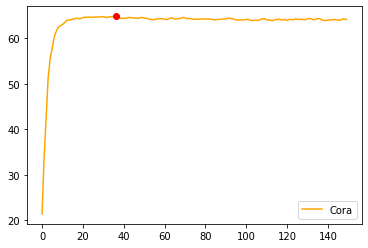

In [0]:
axisX = range(n_of_epochs)

plt.plot(axisX, accPointsCora_our, color='orange', label='Cora')
#plt.plot(axisX, pointsPubMed, color='blue', label='PubMed')
plt.plot([maxAccCora_our], accPointsCora_our[maxAccCora_our], marker='o', color='red')
#plt.plot([maxAccPubMed], pointsPubMed[maxAccPubMed], marker='o', color='blue')
plt.legend()
plt.show()

In [0]:
print("Max accuracy Cora at {:03d} epochs with value {:05f}"
  .format(maxAccCora_our, accPointsCora_our[maxAccCora_our]))
#print("Max accuracy PubMed at {:03d} epochs with value {:05f}"
#  .format(maxAccPubMed, pointsPubMed[maxAccPubMed]))

Max accuracy Cora at 036 epochs with value 64.810199


Loss values of our algorithm

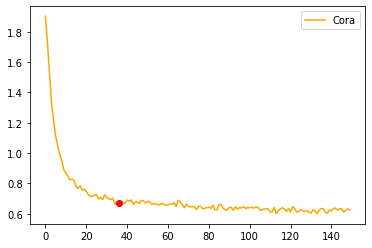

In [0]:
plt.plot(axisX, lossPointsCora_our, color='orange', label='Cora')
#plt.plot(axisX, pointsLossPubMed, color='blue', label='PubMed')
plt.plot([maxAccCora_our], lossPointsCora_our[maxAccCora_our], marker='o', color='red')
#plt.plot([maxAccPubMed], pointsLossPubMed[maxAccPubMed].item(), marker='o',color='blue')
plt.legend()
plt.show()

In [0]:
print("For Cora, at epoch {:03d}, loss was {:05f}"
  .format(maxAccCora_our, lossPointsCora_our[maxAccCora_our]))
#print("For PubMed, at epoch {:03d}, loss was {:05f}"
#  .format(maxAccPubMed, pointsLossPubMed[maxAccPubMed]))

For Cora, at epoch 036, loss was 0.671697


#Comparison

Comparison between accuracy of both algorithms. The red dots show the maximum values reached.

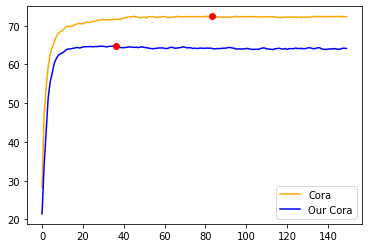

In [0]:
plt.plot(axisX, accPointsCora, color='orange', label='Cora')
plt.plot(axisX, accPointsCora_our, color='blue', label='Our Cora')
plt.plot([maxAccCora], accPointsCora[maxAccCora], marker='o', color ='red')
plt.plot([maxAccCora_our], accPointsCora_our[maxAccCora_our], marker='o', color='red')

plt.legend()
plt.show()

Comparison between the loss values of both algorithm. The red dots shows the loss values when the accuracy is at its maximum.

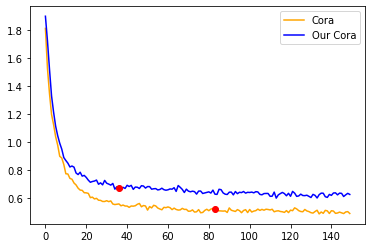

In [0]:
plt.plot(axisX, lossPointsCora, color='orange', label='Cora')
plt.plot(axisX, lossPointsCora_our, color='blue', label='Our Cora')
plt.plot([maxAccCora], lossPointsCora[maxAccCora], marker='o', color ='red')
plt.plot([maxAccCora_our], lossPointsCora_our[maxAccCora_our], marker='o', color='red')

plt.legend()
plt.show()